# Questão 3

Para resolver a questão 3, precisamos de 4 etapas: Gerar os dados de forma aleatória, separar os dados corretamente, treinar o modelo e conferir os resultados do treinamento.

In [ ]:
# Imports

import pandas as pd
import numpy as np
import random
from scipy.spatial import distance
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

## Gerando o dataset

In [4]:
data = []

# Dataset com 10000 valores
num_total = 10000
origem = (0,0)

cont_dados = 0
cont_classes = {}
for i in range(1,9):
    cont_classes[f'C{i}'] = 0

while cont_dados < num_total:

    # Gerar pontos x e y, garantindo que estejam no círculo de raio 1
    while True:
        xval = random.uniform(-1, 1)
        yval = random.uniform(-1, 1)
        ponto = (xval,yval)
        dist = distance.euclidean(origem, ponto)

        if dist <= 1:
            break
    
    # Calcular em qual classe estão localizadas
    def dentro_losango(x, y):
        if abs(x) + abs(y) <= 1:
            return True
        return False
        
    #C1 ou C5
    if xval >= 0 and yval >= 0:
        if dentro_losango(xval,yval):
            classe = 'C1'
        else:
            classe = 'C5'

    #C2 ou C6
    elif xval < 0 and yval >= 0:
        if dentro_losango(xval,yval):
            classe = 'C2'
        else:
            classe = 'C6'

    #C4 ou C8
    elif xval >=0 and yval < 0:
        if dentro_losango(xval,yval):
            classe = 'C4'
        else:
            classe = 'C8'
    #C3 ou C7
    else:
        if dentro_losango(xval,yval):
            classe = 'C3'
        else:
            classe = 'C7'

    # Garantir que as classes estão igualmente distribuídas
    if cont_classes[classe] >= num_total//8:
        continue
    else:
        cont_classes[classe] += 1
        cont_dados += 1

    data.append({'x_val':xval, 'y_val':yval, 'classe':classe})

data_df = pd.DataFrame(data)

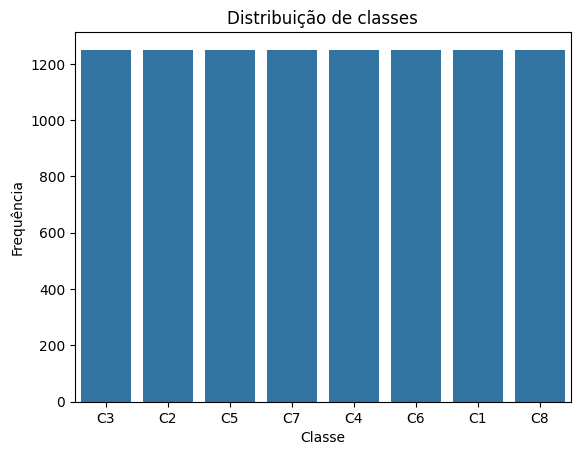

In [5]:
# Demonstração gráfica do balanceamento de classes
sns.countplot(data=data_df, x='classe')
plt.xlabel('Classe')
plt.ylabel('Frequência')
plt.title('Distribuição de classes')
plt.show()

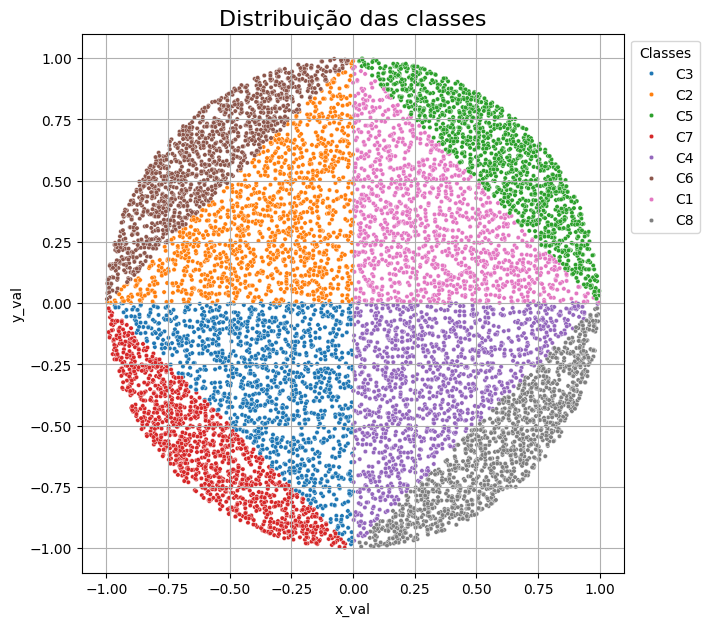

In [6]:
# Demonstração gráfica que a labelização foi correta
plt.figure(figsize=(7, 7))
sns.scatterplot(x='x_val', y='y_val', data=data_df, hue='classe', palette='tab10', s=10)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.title("Distribuição das classes", fontsize=16)
plt.grid()
plt.legend(title='Classes', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

## Preparando o dataset

In [7]:
label_encoder = LabelEncoder()
# Encodando as labels de saída
encoded_labels = label_encoder.fit_transform(data_df['classe'].values)

In [30]:
# Dividindo entre treino e teste com pytorch
X = torch.tensor(data_df[['x_val','y_val']].values, dtype=torch.float32)
y = torch.tensor(encoded_labels).long()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [31]:
# Definindo os loaders
loaders = {
    'train': DataLoader(
        list(zip(X_train, y_train)),
        batch_size=4,
        shuffle=True
    ),
    'test': DataLoader(
        list(zip(X_test, y_test)),
        batch_size=4,
        shuffle=True
    )
}

## Definindo funções do modelo

In [10]:
# Classe com definição do Perceptron
class Perceptron(nn.Module):
    def __init__(self, input_size, output_size):
        super(Perceptron, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Função para treinar o perceptron com o valor do momento e número de épocas customizados
def train_perceptron(train_loader,momentum, n_epocas):
    input_size = 2
    output_size = 8
    model = Perceptron(input_size, output_size)

    # Definindo loss e optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=momentum)
    losses = []

    # Treinando o modelo
    for epoch in range(n_epocas):
        for inputs, targets in train_loader:
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(loss.item())

    plt.plot(losses)
    
    return model

In [11]:
def test_model(model,test_loader):
    model.eval()

    correct = 0
    total = 0

    all_labels = []
    all_predictions = []

    # Testando o modelo para obter acurácia e matriz de confusão
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to('cpu'), labels.to('cpu')
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy, all_labels, all_predictions

## Usando a regra delta convencional

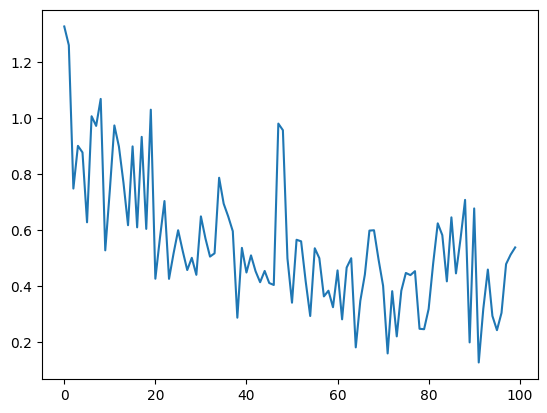

In [32]:
model_delta = train_perceptron(loaders['train'],0, 100)
acc, all_labels, all_predictions = test_model(model_delta,loaders['test'])

In [33]:
print(f"Acurácia: {acc}")

Acurácia: 0.936


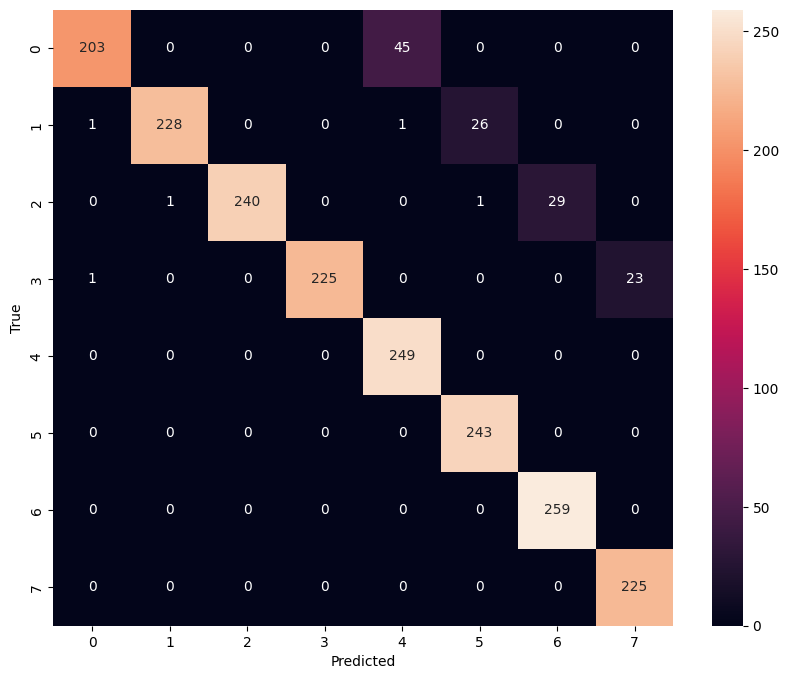

In [34]:
cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Usando a regra delta do momento

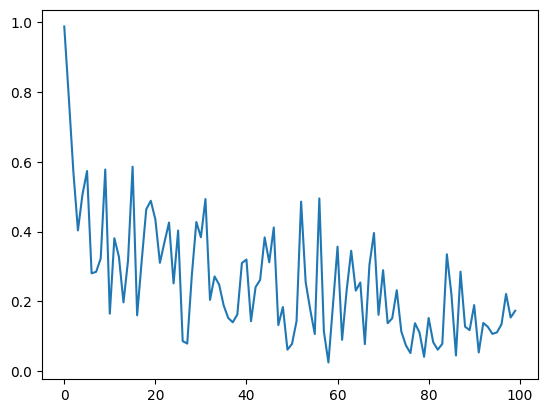

In [35]:
model_momento = train_perceptron(loaders['train'],0.9,100)
acc_momento, all_labels, all_predictions = test_model(model_momento,loaders['test'])

In [36]:
print(f"Acurácia: {acc_momento}")

Acurácia: 0.97


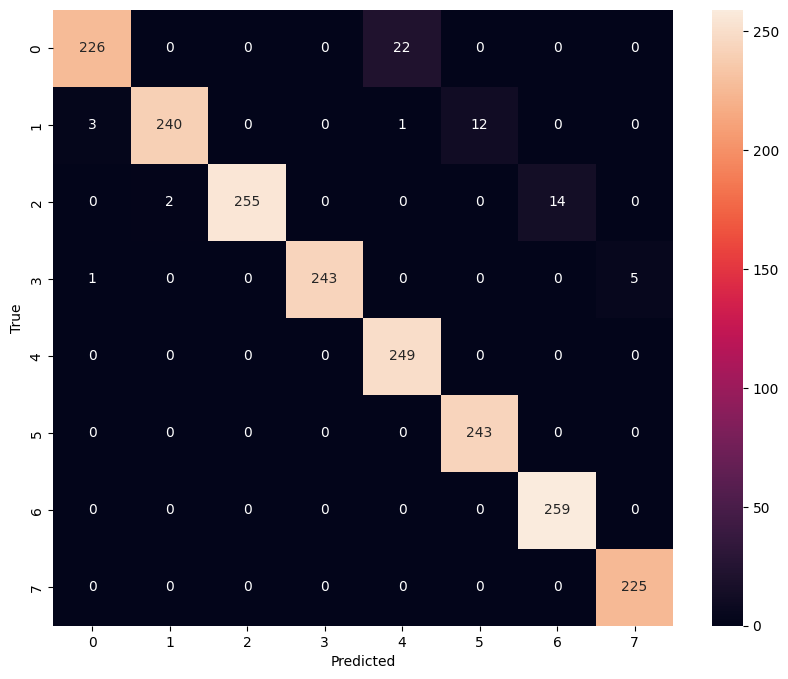

In [37]:
cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()